## Parameter estimates for correlated regressors

By JB Poline and Matthew Brett.

In [1]:
# Compatibility with Python 3
from __future__ import print_function  # print('me') instead of print 'me'
from __future__ import division  # 1/2 == 0.5, not 0

In [2]:
# Array and plotting libraries
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
# Display plots inside the notebook

In [5]:
# Make numpy print 4 significant digits for prettiness
np.set_printoptions(precision=4, suppress=True)

In [6]:
# Set random number seed to make random numbers reproducible
np.random.seed(42)

## The linear model again

We have some vector of data $\vec{y}$ with values
$y_1, y_2, ..., y_N$.

We have one or more vectors of regressors
$\vec{x_1}, \vec{x_2}, ..., \vec{x_P}$, where $\vec{x_1}$
has values $x_{1,1}, x_{1,2}, ..., x_{1,N}$, and $\vec{x_p}$
has values $x_{p,1}, x_{p,2}, ..., x_{p,N}$.

Our linear model says that:

$$
\vec{y} = \beta_1 \vec{x_1} + \beta_2 \vec{x_2} +  ... + \beta_P \vec{x_P} + \vec{\varepsilon}
$$

Here:

* $\beta_1, \beta_2, ... \beta_P$ are scaling coefficients for
  vectors $\vec{x_1}, \vec{x_2}, ..., \vec{x_P}$ respectively;

* $\vec{\varepsilon} = \varepsilon_1, \varepsilon_2, ... \varepsilon_N$
  are the remaining unexplained errors for each observation.

Usually one of vectors $\vec{x}$ is a vector of constant value 1.
This models the intercept of the regression model. We will write this
special vector as $\vec{1}$.

As we saw in the [introduction to the general linear
model](http://perrin.dynevor.org/glm_intro.html), we can express this
same linear model as matrices. We:

* assemble the $\vec{x_p}$ vectors as columns in a design matrix
  $\mathbf{X} = [\vec{x_1}, \vec{x_2}, ... \vec{x_P}]$;

* assemble the $\beta_p$ coefficients into a vector
  $\vec{\beta} = \beta_1, \beta_2, ..., \beta_P$.

Then matrix multiplication does the rest:

$$
\vec{y} = \mathbf{X} \cdot \vec{\beta} + \vec{\varepsilon}
$$

## Models with correlated regressors

### Some correlated regressors

Imagine we have a TR (image) every 2 seconds, for 30 seconds. Here are
the times of the TR onsets, in seconds:

In [7]:
times = np.arange(0, 30, 2)
times

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28])

Now we make a hemodynamic response function (HRF) shape for an event
starting at time 0. Call this `hrf1`:

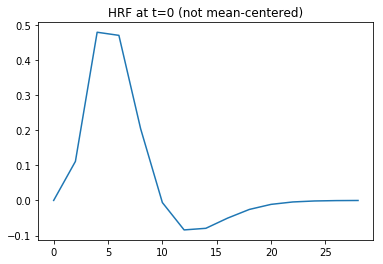

In [8]:
# Gamma distribution from scipy
from scipy.stats import gamma

# Make SPM-like HRF shape with gamma for peak and undershoot
hrf1 = gamma.pdf(times, 6) - 0.35 * gamma.pdf(times, 12)
# Scale area under curve to 1
hrf1 = hrf1 / np.sum(hrf1)
# Plot
plt.plot(times, hrf1)
plt.title('HRF at t=0 (not mean-centered)')

Now we make another HRF starting at t=2 (at the beginning of the second
TR):

In [9]:
# HRF starting at t=2
hrf2 = np.zeros(hrf1.shape)
hrf2[1:] = hrf1[0:-1]

For simplicity, we remove the mean from these regressors. We do this to
make the HRF regressors independent of the mean ($\vec{1}$)
regressor, but it may not be clear yet why that is a good idea.

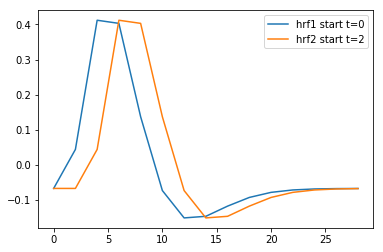

In [10]:
# Remove the mean from both HRF regressors
hrf1 = (hrf1 - hrf1.mean())
hrf2 = (hrf2 - hrf2.mean())
plt.plot(times, hrf1, label='hrf1 start t=0')
plt.plot(times, hrf2, label='hrf2 start t=2')
plt.legend()

These `hrf1` and `hrf2` regressors are correlated. The Pearson
correlation coefficient between the HRFs is:

In [11]:
np.corrcoef(hrf1, hrf2)

array([[ 1.    ,  0.7023],
       [ 0.7023,  1.    ]])

# Some simulated data

Now we are going to make some simulated data from the *signal* formed
from the correlated regressors, plus some random *noise*.

The *signal* comes from the sum of `hrf1` and `hrf2`. This simulates
the occurence of two events, one starting at t=0, one at t=2, both
causing an HRF response:

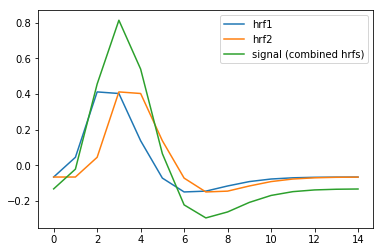

In [12]:
signal = hrf1 + hrf2
plt.plot(hrf1, label='hrf1')
plt.plot(hrf2, label='hrf2')
plt.plot(signal, label='signal (combined hrfs)')
plt.legend()

The simulated data is this signal combined with some random noise:

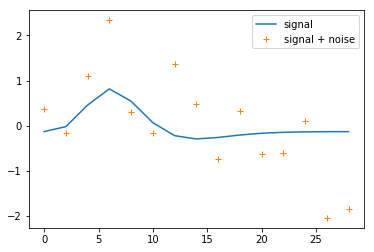

In [13]:
noise = np.random.normal(size=times.shape)
Y = signal + noise
plt.plot(times, signal, label='signal')
plt.plot(times, Y, '+', label='signal + noise')
plt.legend()

We are going apply several linear models to these simulated data.

All our models include a regressor of a vector of ones, $\vec{1}$,
modeling the mean.

We will call our `hrf1` vector $\vec{h_1}$. Call `hrf2` :
$\vec{h_2}$.

Our models are:

* A model with $\vec{x}$ vectors $\vec{h_1}, \vec{1}$ -
  single HRF model);

* A model with $\vec{h_1}, \vec{h_2}, \vec{1}$ - both HRFs model;

* A model with $\vec{h_1}, \vec{w}, \vec{1}$, where
  $\vec{w}$ is $\vec{h_2}$ (`hrf2`) *orthogonalized with
  respect to* $\vec{h_1}$ (`hrf1`). We explain what we mean by
  this further down the page.

First, the model with $\vec{h_1}, \vec{1}$:

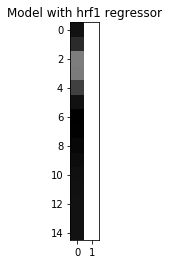

In [14]:
# Design matrix for single HRF model
X_s = np.vstack((hrf1, np.ones_like(hrf1))).T
plt.imshow(X_s, interpolation='nearest', cmap='gray')
plt.title('Model with hrf1 regressor')

Simulating the effect of noise on parameter estimates

Remember that the students-t statistic is:

$$
t = \frac{c^T \hat\beta}{\sqrt{\mathrm{var}(c^T \hat\beta)}}
$$

where $c^T$ is a row vector of contrast weights,
$\hat{\beta}$ is our vector of estimated parameters, and
$\mathrm{var}(c^T \hat\beta)$ is the variance of
$c^T \hat\beta$.

On the assumption of zero mean normally distributed independent noise:

$$
\mathrm{var}(c^T \hat\beta) = \hat{\sigma}^2 c^T (X^T X)^+ c
$$

where $\hat{\sigma}^2$ is our estimate of variance in the
residuals, and $(X^T X)^+$ is the
[pseudo-inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_pseudoinverse)
of $X^T X$.

Therefore:

$$
t = \frac{c^T \hat\beta}{\sqrt{\hat{\sigma}^2 c^T (X^T X)^+ c}}
$$

We will see that this expection of variance correctly predicts that
parameter estimates for correlated regressors will have higher variance
for a given level of noise (where the level of noise can be captured by
$\hat{\sigma}^2$).

Put another way, the parameter estimates of correlated regressors are
more susceptible to the effect of noise.

We can look at the variability of the parameter estimates, by estimating
our models on many different simulated data vectors.

Each of the data vectors are made of the *signal* (the sum of `hrf1`
and `hrf2`) and some *noise*. We take a new sample of noise for each
data vector:

In [15]:
# Create array of simulated data vectors in columns
n_times = len(times) # number of elements in single data vector
n_data_vectors = 100000
# Make many noise vectors (new noise for each column)
noise_vectors = np.random.normal(size=(n_times, n_data_vectors))
# add signal to make data vectors
# Use numpy broadcasting to add vector elementwise to 2D array
Ys = noise_vectors + signal.reshape(n_times, 1)
Ys.shape

(15, 100000)

We first fit the model with only the first HRF regressor to every
(signal + noise) sample vector.

We will fit our model for each data vector, to make a estimated
parameter vector for each data vector. We can stack these estimated
parameter vectors into a 2 by `n_data_vectors` array.

Call this array $\beta^s$ (where the $s$ superscript is for
the *single* HRF model).

In [16]:
# Fit X_one to signals + noise
n_regressors = X_s.shape[1]
# beta (parameter estimate) matrix, one column per data vector
B_s = np.zeros((n_regressors, n_data_vectors))
# Estimate the parameters of the model for each data vector
X_pinv = npl.pinv(X_s)
for i in range(n_data_vectors):
    B_s[:, i] = X_pinv.dot(Ys[:, i])

In fact, because of the way that matrix multiplications works, we can do
exactly the same calculation as we did in the loop above, in one matrix
multiplication:

In [17]:
B_again = X_pinv.dot(Ys)
assert np.allclose(B_s, B_again)

We will use this trick to estimate the parameter matrices for the rest
of our models.

Let us look at the variance of the first parameter estimate (the
parameter for the `hrf1` regressor).

Here is the variance we observe:

Observed B[0] variance for single hrf model: 2.2014181026


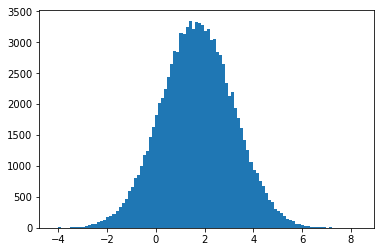

In [18]:
plt.hist(B_s[0], bins=100)
print('Observed B[0] variance for single hrf model:', np.var(B_s[0]))

Observed B[0] variance for single hrf model: 2.2014181026

We can compare the observed variance of the first parameter estimate
with that expected from the formula above:

$$
\mathrm{var}(c^T \hat\beta) = \hat{\sigma}^2 c^T (X^T X)^+ c
$$

To select only the first regressor, we use a contrast vector of

$$
c = \left[
\begin{array}{\cvec}
1 \\
0 \\
\end{array}
\right]
$$

Our $\hat{\sigma}^2$ will be close to 1, because we added noise
with variance 1:

In [19]:
# Estimate sigma^2 for every data vector
predicted = X_s.dot(B_s)
residuals = Ys - predicted
# Residuals have N-P degrees of freedom
N = n_times
P = npl.matrix_rank(X_s) # number of independent columns in design
sigma_hat_squared = (residuals ** 2).sum(axis=0) / (N - P)
print('Mean sigma^2 estimate:', np.mean(sigma_hat_squared))

Mean sigma^2 estimate: 1.01981361247


Mean sigma^2 estimate: 1.01981361247

Because $\hat{\sigma}^2 \approx 1$,
$\mathrm{var}(c^T \hat\beta) \approx c^T (X^T X)^+ c$:

In [20]:
C_s = np.array([[1], [0]]) # column vector
# c.T{X.T X}+ c
C_s.T.dot(npl.pinv(X_s.T.dot(X_s)).dot(C_s))

array([[ 2.2051]])

Notice that the mean of the parameter estimates for
$:raw-latex: (`hrf1`), is somewhere above one, even though
we only added 1 times the first HRF as the signal:

In [21]:
print('Observed B[0] mean for single hrf model:', np.mean(B_s[0]))

Observed B[0] mean for single hrf model: 1.70147967742


Observed B[0] mean for single hrf model: 1.70147967742

This is because the single first regresssor has to fit *both*
$\vec{h_1}$ in the signal, and as much as possible of
$\vec{h_2}$ in the signal, because there is nothing else in the
model to fit $\vec{h_2}$.

Now let us construct the model with both HRFs as regressors:

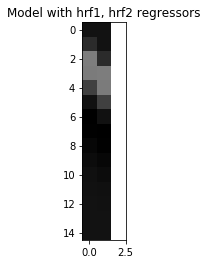

In [22]:
# Design matrix for both HRFs model
X_b = np.vstack((hrf1, hrf2, np.ones_like(hrf1))).T
plt.imshow(X_b, interpolation='nearest', cmap='gray')
plt.title('Model with hrf1, hrf2 regressors')

We will call the resulting 3 by `n_data_vectors` parameter array :
$\beta^b$ (where the $b$ superscript is for *both* HRF
regressors).

We will use the matrix multiplication trick above to fit all the data
vectors at the same time:

In [23]:
# Fit X_both to signals + noise
B_b = npl.pinv(X_b).dot(Ys)

What estimates do we get for the first regressor, when we have both
regressors in the model?

Observed B[0] mean for two hrf model 1.00299905499
Observed B[0] variance for two hrf model 4.35228828591


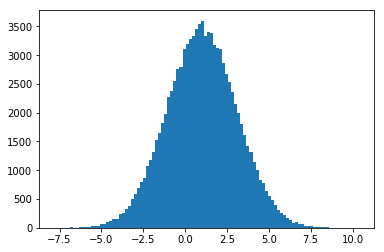

In [24]:
plt.hist(B_b[0], bins=100)
print('Observed B[0] mean for two hrf model', np.mean(B_b[0]))
print('Observed B[0] variance for two hrf model', np.var(B_b[0]))

Observed B[0] mean for two hrf model 1.00299905499
Observed B[0] variance for two hrf model 4.35228828591

Two things have happened now we added the second (correlated)
$\vec{h_2}$ regressor. First, the mean of the parameter for the
$\vec{h_1}$ regressor has dropped to 1, because
$\beta^b_1 \vec{h_1}$ is no longer having to model the signal due
to $\vec{h_2}$. Second, the variability of the estimate has
increased. This is what the bottom half of the t-statistic predicts:

In [25]:
# Predicted variance for hrf1 parameter in both HRF model
C_b = np.array([[1], [0], [0]])  # column vector
C_b.T.dot(npl.pinv(X_b.T.dot(X_b)).dot(C_b))

array([[ 4.3517]])

The estimate of the parameter for $\vec{h_2}$ has a mean of around
1, like the parameter estimates for $\vec{h_1}$:

Observed B[1] mean for two hrf model 0.994534456872


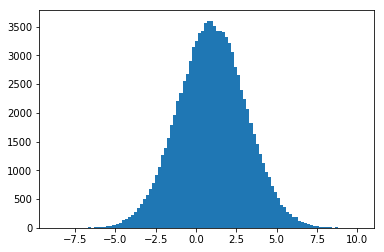

In [26]:
plt.hist(B_b[1], bins=100)
print('Observed B[1] mean for two hrf model', np.mean(B_b[1]))

Observed B[1] mean for two hrf model 0.994534456872

This mean of 1 is what we expect because we have
$\vec{h_1} + \vec{h_2}$ in the signal. Not surprisingly, the
$\vec{h_2}$ parameter estimate has a similar variability to that
for the $\vec{h_1}$ parameter estimate:

In [27]:
print('Observed B[1] variance for two hrf model', np.var(B_b[1]))

Observed B[1] variance for two hrf model 4.37230501038


Observed B[1] variance for two hrf model 4.37230501038

The observed variance is very similar to the predicted variance:

In [28]:
C_b_1 = np.array([0, 1, 0])[:, None]  # column vector
C_b_1.T.dot(npl.pinv(X_b.T.dot(X_b)).dot(C_b_1))

array([[ 4.3519]])

The parameter estimates for $\vec{h_1}$ and $\vec{h_2}$ are
anti-correlated:

array([[ 1.   , -0.703],
       [-0.703,  1.   ]])

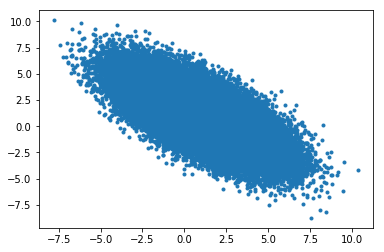

In [29]:
# Relationship of estimated parameter of hrf1 and hrf2
plt.plot(B_b[0], B_b[1], '.')
np.corrcoef(B_b[0], B_b[1])

## Orthogonalizing hrf2 with respect to hrf1

$\vec{h_2}$ is correlated with $:raw-latex:.

We can therefore think of $\vec{h_2}$ as the sum of some scaling
of $\vec{h_1}$ plus an extra part that cannot be explained by
$\vec{h_1}$.

$$
\vec{h_2} = p (\vec{h_1}) + \vec{w}
$$

where $p$ is some scalar, and

$$
\vec{w} = \vec{h_2} - p (\vec{h_1})
$$

To restate, we can think of $\vec{h_2}$ as the sum of some scalar
amount of $\vec{h_1}$ plus $\vec{w}$.

We want to chose $p$ such that
$\vec{w} = \vec{h_2} - p (\vec{h_1})$ is orthogonal to
$\vec{h_1}$. In this case $\vec{w}$ is the part of
$\vec{h_2}$ that cannot be explained by $\vec{h_1}$.

If $\vec{w}$ is orthogonal to $\vec{h_1}$ then we call
$\vec{w}$ : $\vec{h_2}$ *orthogonalized with respect to*
$\vec{h_1}$.

Following the same logic as for
[projection](http://practical-neuroimaging.github.io/day7.html#key-video-on-projecting-vectors),
given $\vec{w} - p (\vec{h_1})$ is orthogonal to
$\vec{h_1}$:

$$
(\vec{w} - p (\vec{h_1})) \cdot \vec{h_1} = 0 \implies \\
\vec{w} \cdot \vec{h_1} - p (\vec{h_1}) \cdot \vec{h_1} = 0 \implies \\
\frac{\vec{w} \cdot \vec{h_1}}{\vec{h_1} \cdot \vec{h_1}} = p
$$

Put another way, $p (\vec{h_1})$ such that
$\vec{w} = \vec{h_2} - p (\vec{h_1})$ is orthogonal to
$\vec{h_1}$ - is also the projection of $\vec{h_2}$ onto
$\vec{h_1}$.

In [30]:
# Project hrf2 onto hrf1
p = hrf2.dot(hrf1) / hrf1.dot(hrf1)
projection = p * hrf1
# Get \vec{w}
w = hrf2 - projection
# w and hrf1 are now orthogonal
assert np.allclose(w.dot(hrf1), 0)

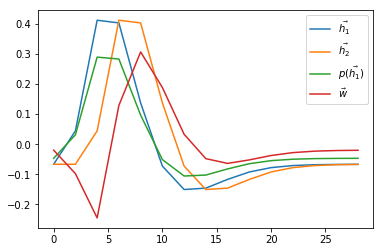

In [31]:
# Plot the vector parts
plt.plot(times, hrf1, label=r'$\vec{h_1}$')
plt.plot(times, hrf2, label=r'$\vec{h_2}$')
plt.plot(times, projection, label=r'$p (\vec{h_1})$')
plt.plot(times, w, label=r'$\vec{w}$')
plt.legend()
# hrf1 part of hrf2, plus unique part, equals original hrf2
assert np.allclose(hrf2, projection + w)

How much of the first regressor did we find in the second regressor?

In [32]:
p

0.70231917818451139

Let us rewrite our original model containing `hrf1, hrf2`:

$$
\vec{y} = \beta^b_1 \vec{h_1} + \beta^b_2 \vec{h_2} + \beta^b_3 1
$$

where $\vec{y}$ is our data vector.

Now we know we can also write this as:

$$
\vec{y} = \beta^b_1 \vec{h_1} +
  \beta^b_2 (p (\vec{h_1}) + \vec{w}) + \beta^b_3 1 \\
= \beta^b_1 \vec{h_1} +
  \beta^b_2 p (\vec{h_1}) + \beta^b_2 \vec{w} + \beta^b_3 1 \\
= (\beta^b_1 + p \beta^b_2) \vec{h_1} + \beta^b_2 \vec{w} + \beta^b_3 1
$$

So, what will happen if we drop $\vec{h_2}$ from our model and
leave only $\vec{w}$?

We have called the parameters from the model with
$\vec{h_1}, \vec{h_2}$ : $\beta^b$. Call the parameters from
the model with $\vec{h_1}, \vec{w}$ : $\beta^w$.

We can see that we are going to get the exact same fit to the data with
these two models if $\beta^w_2 = \beta^b_2$ and
$\beta^w_1 = p \beta^b_2 + \beta^b_1$.

Let us try this new model and see:

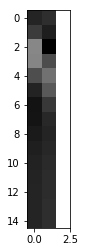

In [33]:
X_w = np.vstack((hrf1, w, np.ones_like(hrf1))).T
plt.imshow(X_w, interpolation='nearest', cmap='gray')

In [34]:
# Fit the model
B_w = npl.pinv(X_w).dot(Ys)

Let us first look at the distribution of $\beta^w_1$
`== B_w[0]`.

Observed B[0] mean for two hrf orth model 1.70147967742


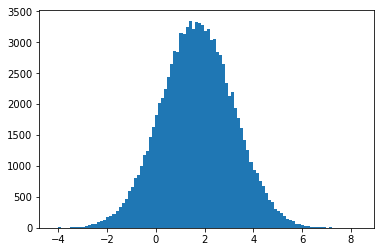

In [35]:
# Distribution of parameter for hrf1 in orth model
plt.hist(B_w[0], bins=100)
print('Observed B[0] mean for two hrf orth model',
      np.mean(B_w[0]))

Observed B[0] mean for two hrf orth model 1.70147967742

Notice that $\beta^w_1$ now has the same values as for the single
HRF model : $\beta^s_1$:

In [36]:
assert np.allclose(B_s[0, :], B_w[0, :])

It therefore has the same variance, and the predicted variance matches:

In [37]:
print('Observed B[0] variance for two hrf orth model', np.var(B_w[0]))
pred_var = C_b.T.dot(npl.pinv(X_w.T.dot(X_w)).dot(C_b))
print('Predicted B[0] variance for two hrf orth model', pred_var)

Observed B[0] variance for two hrf orth model 2.2014181026
Predicted B[0] variance for two hrf orth model [[ 2.2051]]


Observed B[0] variance for two hrf orth model 2.2014181026
Predicted B[0] variance for two hrf orth model [[ 2.2051]]

The fact that the single hrf and orthogonalized model parameters match
may make sense when we remember that adding the $\vec{w}$
regressor to the model cannot change the parameter for the
$\vec{h_1}$ regressor as $\vec{w}$ is orthogonal to
$\vec{h_1}$.

We predicted above that $\beta^w_2$ would stay the same as
$\beta^b_2$ from the not-orthogonalized model:

In [38]:
assert np.allclose(B_b[1, :], B_w[1, :])

We predicted that $\beta^w_1$ would become
$\beta^b_1 + p \beta^b_2$ from the not-orthogonalized model:

In [39]:
predicted_beta1 = B_b[0, :] + p * B_b[1, :]
assert np.allclose(predicted_beta1, B_w[0, :])

Our predictions were correct. So let us revise what happened:

* We estimated our original model with correlated
  $\vec{h_1}, \vec{h_2}$ to get corresponding estimated
  parameters $\beta^b_1, \beta^b_2$;

* we orthogonalized $\vec{h_2}$ with respect to $\vec{h_1}$
  to give $p$ and $\vec{w}$;

* we replaced $\vec{h_2}$ with $\vec{w}$ in the model, and
  re-estimated, giving new parameters $\beta^w_1$ for
  $\vec{h_1}$, $\beta^w_2$ for $\vec{w}$;

* $\beta^w_2 = \beta^b_2$ - the parameter for the new
  orthogonalized regressor is unchanged from the non-orthogonalized
  case;

* $\beta^w_1 = \beta^b_1 + p \beta^b_2$ - the parameter for the
  *unchanged* regressor has increased by $\beta^b_2$ times the
  amount of $\vec{h_2}$ present in $\vec{h_1}$.

Here we show some example parameters from the three model fits:

In [40]:
# Example parameters from the single hrf model
B_s[:,:5]

array([[ 0.0032,  1.2188,  2.289 ,  0.2179,  3.45  ],
       [-0.0969,  0.0488,  0.006 , -0.1493, -0.4889]])

In [41]:
# Example parameters from the non-orth two-hrf model
B_b[:,:5]

array([[-1.3014,  1.676 ,  0.3588, -0.6153,  0.8819],
       [ 1.8574, -0.6509,  2.7482,  1.1865,  3.6566],
       [-0.0969,  0.0488,  0.006 , -0.1493, -0.4889]])

In [42]:
# Example parameters from the orth model
B_w[:,:5]

array([[ 0.0032,  1.2188,  2.289 ,  0.2179,  3.45  ],
       [ 1.8574, -0.6509,  2.7482,  1.1865,  3.6566],
       [-0.0969,  0.0488,  0.006 , -0.1493, -0.4889]])

array([[ 1.    ,  0.7103],
       [ 0.7103,  1.    ]])

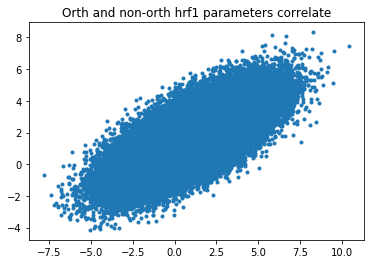

In [43]:
# The parameter for the hrf1 regressor in the non-orth model
# is correlated with the parameter for the hrf1 regressor
# in the orth model.
plt.plot(B_b[0], B_w[0], '.')
plt.title('Orth and non-orth hrf1 parameters correlate')
np.corrcoef(B_b[0], B_w[0])

array([[ 1.    ,  0.0013],
       [ 0.0013,  1.    ]])

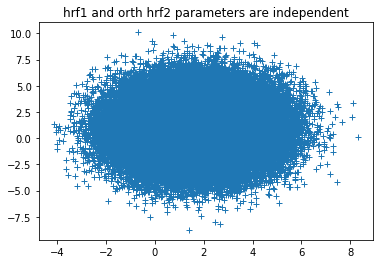

In [44]:
# Relationship of estimated parameters for hrf1 and orthogonalized hrf2
# (they should be independent)
plt.plot(B_w[0], B_w[1], '+')
plt.title('hrf1 and orth hrf2 parameters are independent')
np.corrcoef(B_w[0], B_w[1])